In [34]:
#fusionner les sous classes/ supprimer les benins pour les modeles multiclasses

### 0. Initial Configuration

Necesssary libraries are imported. 
The MLPs is implemented via keras. 
Additionally, reproducibility is established.

In [1]:
# 0.1 - General Purpose Libraries/Modules

# for linear algebra
import numpy as np
# for data processing and file I/O
import pandas as pd
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# measuring latency
import time

# Encode categorical target variable into numerical labels
from sklearn.preprocessing import LabelEncoder
# for data preparation
from sklearn.model_selection import train_test_split
# for feature engineering and data scaling
from sklearn.preprocessing import Normalizer, QuantileTransformer
# for feature engineering
from sklearn.feature_selection import mutual_info_classif
# for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# for SMOTE
from imblearn.over_sampling import SMOTE
# for confusion matrix
from sklearn.metrics import confusion_matrix

# for I/O & automatic EDA
import os
# for suppressing warnings
import warnings
# for reating the report
from IPython.display import display, HTML
# Attention: Importing this module on GPU creates bugs
#from ydata_profiling import ProfileReport

In [2]:
# 0.2 - The MLPs are implemented via keras

# for feature selection
from xgboost import XGBClassifier

# basic configuration
import tensorflow as tf
from tensorflow import keras

# for the implemantation of the models
from keras import layers, Sequential
# for readability purposes
from keras.layers import Input, Dense
# for weights initialization
from keras.initializers import GlorotUniform, HeUniform
# for loadig (after saving) the models
from keras.models import load_model

# for the customization of the model and the training process
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# for model visualization
from keras.utils import plot_model

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
# 0.3 - Reproducibility Establishment

# Set seed
seed_pi = 314159

# Set numpy seed
np.random.seed(seed_pi)
# Set the seed for TensorFlow
tf.random.set_seed(seed_pi)

# 1. Dataset Preperation

In this segment, we proceed with dataset loading and preprocessing.

## 1.1 Importing the CIC-IDS-2017 Dataset

The dataset will be loaded from an [Apache Parquet file](https://parquet.apache.org/) into a Pandas DataFrame. It has been properly cleaned and preprocessed by Kaggle user [StrGenIx | Laurens D'hooge](https://www.kaggle.com/datasets/dhoogla/cicids2017).

### 1.1.1 - Directory Inspection 

In [4]:
# 1.1.1 - Directory Inspection
# Running this will list all files under the input directory

for dirname, _, filenames in os.walk('C:\datasets\parquets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\datasets\parquets\Benign-Monday-no-metadata.parquet
C:\datasets\parquets\Botnet-Friday-no-metadata.parquet
C:\datasets\parquets\Bruteforce-Tuesday-no-metadata.parquet
C:\datasets\parquets\DDoS-Friday-no-metadata.parquet
C:\datasets\parquets\DoS-Wednesday-no-metadata.parquet
C:\datasets\parquets\Infiltration-Thursday-no-metadata.parquet
C:\datasets\parquets\Portscan-Friday-no-metadata.parquet
C:\datasets\parquets\WebAttacks-Thursday-no-metadata.parquet


### 1.1.2 - Loading the datasets into dataframes

In [5]:
df_data_1 = pd.read_parquet('C:\datasets\parquets\Benign-Monday-no-metadata.parquet')
df_data_2 = pd.read_parquet('C:\datasets\parquets\Botnet-Friday-no-metadata.parquet')
df_data_3 = pd.read_parquet('C:\datasets\parquets\Bruteforce-Tuesday-no-metadata.parquet')
df_data_4 = pd.read_parquet('C:\datasets\parquets\DDoS-Friday-no-metadata.parquet')
df_data_5 = pd.read_parquet('C:\datasets\parquets\DoS-Wednesday-no-metadata.parquet')
df_data_6 = pd.read_parquet('C:\datasets\parquets\Infiltration-Thursday-no-metadata.parquet')
df_data_7 = pd.read_parquet('C:\datasets\parquets\Portscan-Friday-no-metadata.parquet')
df_data_8 = pd.read_parquet('C:\datasets\parquets\WebAttacks-Thursday-no-metadata.parquet')

### 1.1.3 - Concatenating the dataframes to single dataframe

In [6]:
df_data = pd.concat([df_data_1, df_data_2, df_data_3, df_data_4, 
                     df_data_5, df_data_6, df_data_7, df_data_8], axis=0, ignore_index=True)

## 1.2 Data Preproccesing

The data preprocessing phase involves the removal of all anomalous samples. In this initial approach, a binary configuration is adopted. During this stage, the features and the target variable are established.

### 1.2.1 - Data preprocessing

#### Find and handle null values

In [7]:
null_counts = df_data.isnull().sum()
# Print the number of null values
print(f"{null_counts.sum()} null entries have been found in the dataset\n")
# Drop null values
df_data.dropna(inplace=True)          # or df_data = df_data.dropna()

0 null entries have been found in the dataset



#### Find and handle duplicates

In [8]:
duplicate_count = df_data.duplicated().sum()
# Print the numer of duplicate entries
print(f"{duplicate_count} duplicate entries have been found in the dataset\n")
# Remove duplicates
df_data.drop_duplicates(inplace=True)  # or df_data = df_data.drop_duplicates()
# Display relative message
print(f"All duplicates have been removed\n")

82004 duplicate entries have been found in the dataset

All duplicates have been removed



In [9]:
# Reset the indexes
df_data.reset_index(drop=True, inplace=True)

# Inspect the dataset for categorical columns
print("Categorical column:",df_data.select_dtypes(include=['object']).columns.tolist(),'\n')

Categorical column: ['Label'] 



#### Overview of the dataset

In [10]:
# Print the first 5 lines
df_data.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.14286,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


#### Nettoyage des noms de colonnes

In [11]:
df_data.columns = df_data.columns.str.strip()
print(" Noms des colonnes après nettoyage :\n", df_data.columns)

 Noms des colonnes après nettoyage :
 Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Cou

### 1.2.2 Inspection of Target Feature

In [12]:
print('Shape of Dataframe: ',df_data.shape,'\n')
print('Inspection of Target Feature - y:\n')
# Target feature counts
print(df_data['Label'].value_counts())
# Alternatively:
# df_data.Label.value_counts()

Shape of Dataframe:  (2231806, 78) 

Inspection of Target Feature - y:

Label
Benign                        1895314
DoS Hulk                       172846
DDoS                           128014
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
PortScan                         1956
Web Attack � Brute Force         1470
Bot                              1437
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [13]:
# Fusionner les classes similaires
df_data["Label"] = df_data["Label"].replace({
    "DoS Hulk": "DoS",
    "DoS GoldenEye": "DoS",
    "DoS slowloris": "DoS",
    "DoS Slowhttptest": "DoS",
    "DoS":"DoS",
    "DDoS":"DoS",
    "Web Attack � Brute Force": "Web Attack",
    "Web Attack � XSS": "Web Attack",
    "Web Attack � Sql Injection": "Web Attack",
    "FTP-Patator": "BruteForce",  # Fusion avec SSH-Patator
    "SSH-Patator": "BruteForce"
})

# Vérifier les nouvelles classes
print("Classes après fusion :", df_data["Label"].value_counts())

Classes après fusion : Label
Benign          1895314
DoS              321759
BruteForce         9150
Web Attack         2143
PortScan           1956
Bot                1437
Infiltration         36
Heartbleed           11
Name: count, dtype: int64


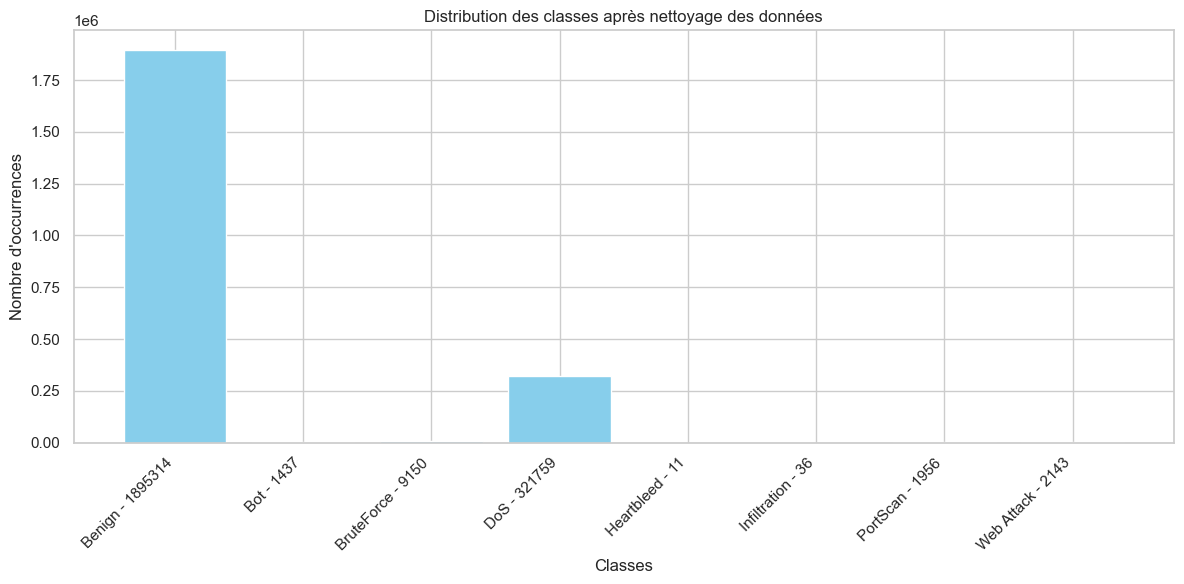

In [106]:
from collections import Counter
import matplotlib.pyplot as plt

# Extraire les labels après nettoyage
y_cleaned = df_data["Label"]

# Compter les occurrences de chaque classe
counter_cleaned = Counter(y_cleaned)

# Préparer les tailles et les étiquettes
sizes = []
labels = []

for label, count in counter_cleaned.items():
    tmp = f"{label} - {count}"
    labels.append(tmp)
    sizes.append(count)

# Création du graphique à barres
fig, ax = plt.subplots(figsize=(12, 6))  # Taille de la figure
ax.bar(labels, sizes, color='skyblue')

# Ajouter des titres et labels
plt.title('Distribution des classes après nettoyage des données')
plt.xlabel('Classes')
plt.ylabel("Nombre d'occurrences")

# Rotation des labels pour éviter le chevauchement
plt.xticks(rotation=45, ha="right")

# Ajustement pour éviter que les labels soient coupés
plt.tight_layout()

# Affichage
plt.show()


### 1.2.3 Set up binary & multi-class configurations

In [16]:
# Extract features as X
X = df_data.copy()
X = X.drop('Label', axis=1)

# Extract binary target as y
y = df_data['Label'].copy()

#### Binary Configuration

In [17]:
# Binarize labels
y_b = y.map({'Benign': 0}).fillna(1)

#### Multi-class Configuration

In [18]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Extract multi-class configuration as y_m
y_m = pd.Series(y_encoded)

#### Inspect encoding

In [19]:
print('Inspection of Target Feature - y under binary Configuration:\n')
y_b.value_counts()
print('Inspection of Target Feature - y under Multiclass Configuration:\n')
y_m.value_counts()

Inspection of Target Feature - y under binary Configuration:

Inspection of Target Feature - y under Multiclass Configuration:



0    1895314
3     321759
2       9150
7       2143
6       1956
1       1437
5         36
4         11
Name: count, dtype: int64

In [20]:
print(label_encoder.classes_)

['Benign' 'Bot' 'BruteForce' 'DoS' 'Heartbleed' 'Infiltration' 'PortScan'
 'Web Attack']


In [21]:
print(f"Unique values in y_b: {y_b.unique()}")
print(f"Unique values in y_m: {y_m.unique()}")

Unique values in y_b: [0. 1.]
Unique values in y_m: [0 1 2 3 4 5 6 7]


#### delete benigns from y_m et x_m 

In [24]:
benign_class_index = list(label_encoder.classes_).index("Benign")

# Supprimer toutes les lignes où y_m == benign_class_index
X_attacks_only = X[y_m != benign_class_index].reset_index(drop=True)
y_attacks_only= y_m[y_m != benign_class_index].reset_index(drop=True)


In [25]:
#### Inspection

In [26]:
print('Inspection of Target Feature - y under Multiclass Configuration:\n')
y_attacks_only.value_counts()

Inspection of Target Feature - y under Multiclass Configuration:



3    321759
2      9150
7      2143
6      1956
1      1437
5        36
4        11
Name: count, dtype: int64

##### redefinir l'encodeur 

In [27]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_attacks_only)
# Extract multi-class configuration as y_m
y_m = pd.Series(y_encoded)

In [28]:
print(label_encoder.classes_)

[1 2 3 4 5 6 7]


### 1.2.4 Visualize class imbalance for both configurations

C:\Users\Admin\AppData\Local\Temp\ipykernel_5892\2281838032.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_b, palette='Greens', ax=axs[0])
C:\Users\Admin\AppData\Local\Temp\ipykernel_5892\2281838032.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y_m, palette='Paired', ax=axs[1])


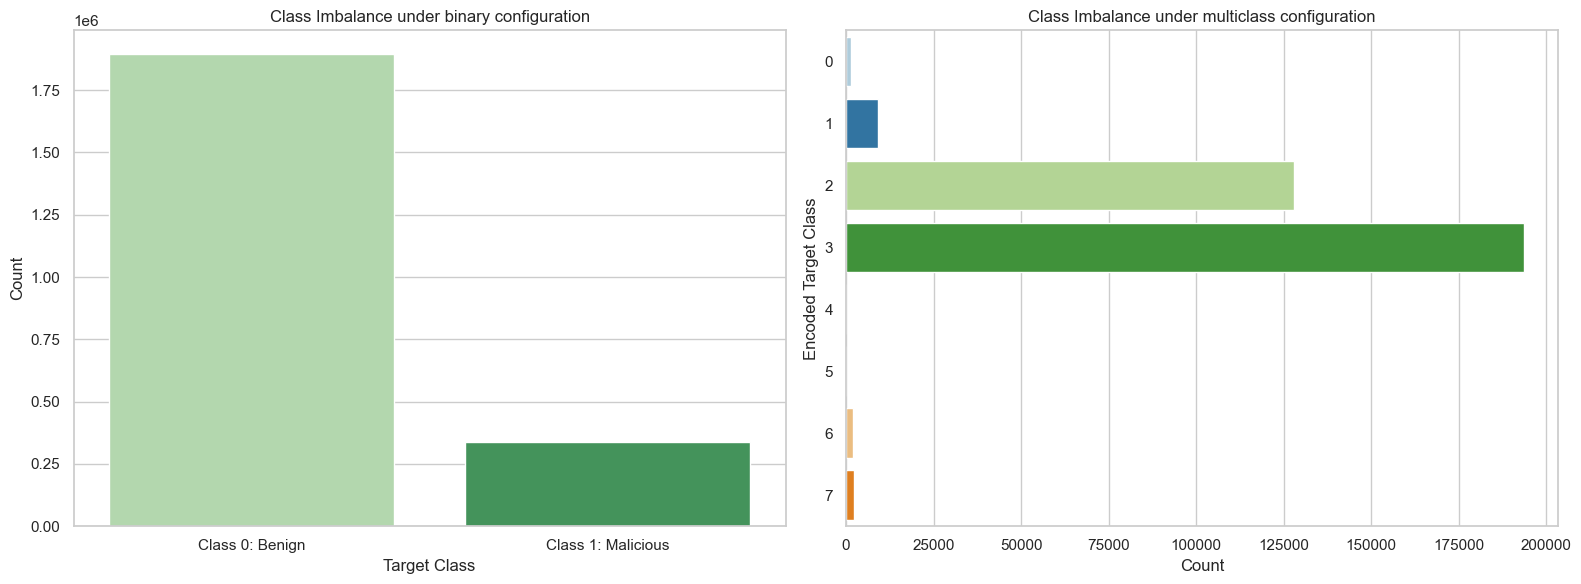

Class Imbalance under binary configuration:

Class 0 ratio: 84.92%
Class 1 ratio: 15.08%

Class Imbalance under multiclass configuration:

Class 3  ratio: 57.5779%
Class 2  ratio: 38.0437%
Class 1  ratio: 2.7192%
Class 7  ratio: 0.6369%
Class 6  ratio: 0.5813%
Class 0  ratio: 0.4271%
Class 5  ratio: 0.0107%
Class 4  ratio: 0.0033%


In [53]:
# Adjusting plot styles
sns.set(style="whitegrid")

# Create a figure and axes (left and right subplots)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the distribution of the binary target variable y_b
sns.countplot(x=y_b, palette='Greens', ax=axs[0])
axs[0].set_title('Class Imbalance under binary configuration')
axs[0].set_xlabel('Target Class')
axs[0].set_ylabel('Count')
axs[0].set_xticks(ticks=[0, 1])
axs[0].set_xticklabels(['Class 0: Benign', 'Class 1: Malicious'])

# Plotting the distribution of the target variable y_m
sns.countplot(y=y_m, palette='Paired', ax=axs[1])
axs[1].set_title('Class Imbalance under multiclass configuration')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Encoded Target Class')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Calculate the count and ratio of each class for y_b
class_counts_b = y_b.value_counts()
class_ratios_b = class_counts_b / len(y_b)

# Print the ratio of each class for y_b
print("Class Imbalance under binary configuration:\n")
print(f"Class 0 ratio: {class_ratios_b[0]*100:.2f}%")
print(f"Class 1 ratio: {class_ratios_b[1]*100:.2f}%")

# Calculate the count and ratio of each class for y_m
class_counts_m = y_m.value_counts()
class_ratios_m = class_counts_m / len(y_m)

# Print the ratio of each class for y_m
print("\nClass Imbalance under multiclass configuration:\n")
for label, ratio in class_ratios_m.items():
    if label < 10:
        print(f"Class {label}  ratio: {ratio*100:.4f}%")
    else:
        print(f"Class {label} ratio: {ratio*100:.4f}%")

> ### Minimum baseline accuracy of 84.92%
The dataset has a majority class (Class 0) making up 84.92% of samples and a minority class (Class 1) at 15.08%. A naive model always predicting the majority class would achieve 84.92% accuracy, setting the minimum baseline. Machine learning or deep learning models, for both binary and multi-class setups, should exceed this baseline to show effective predictive performance.

## 1.3 Splitting the Dataset

In deep learning, it's recommended to split the dataset into training, validation, and test sets to evaluate model performance, tune hyperparameters, and assess generalization on new data.

### 1.3.1 Defining a fuction in order to extract the train, validation and test sets

* Splits a given pandas dataframe X (features) into three subsets:X_train, X_val and X_test. 
    Also splits a given pandas series y (target) to y_train, y_val and y_test respectively. 
    Fractional ratios are provided by the user, as percentages, namely: p_train, p_valid, p_test. 
    These inputs describe the percentage of the extracted sets in reference with the inputs X and y. 
    The final sets are extracted by executing method train_test_split() twice.

    Parameters
    ----------
    X: pandas Dataframe
    y: pandas Series
    p_train, p_val, p_test  : float
    random_state : integer
    shuffle: (boolean) Enables shuffling the dataset
    
    The values should be expressed as float fractions and  should  sum to 1.0.
    The parameter of random_state ensures reproducibility.
    
    Returns
    -------
    X_train, X_val, X_test :
        Dataframes (features) containing the three splits.
    y_train, y_val, y_test  :
        Series (targets) containig the three splits

In [30]:
def extractAllSets(X, y, p_train, p_val, p_test, random_state=seed_pi, shuffle=True):
    # The initial train-test split produces X_train and y_train
    # Two additional sets are created X_temp and y_temp, that will produce the rest of the sets
    X_train, X_temp, y_train, y_temp = train_test_split(X,y,                
                                                        stratify=y,
                                                        test_size=(1.0 - p_train),
                                                        random_state=random_state,
                                                        shuffle=shuffle)  # Enable/disable shuffling
    # Note that by applying the stratify condition we ensure homogeneous distribution 
    # of chareacteristics in targets
    
    # Parameter fraction describes the relevant size of the test size
    fraction = p_test / (p_val + p_test)
    X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,stratify=y_temp,
                                                      test_size=fraction,
                                                      random_state=random_state,
                                                      shuffle=shuffle)  # Enable/disable shuffling
    # Note that we use the same random_state twice for reproducibility
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### 1.3.2 Extract all sets with percentages: 75-10-15 (%) for both configurations

In [35]:
X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b = extractAllSets(
        X,y_b,0.75,0.10,0.15,seed_pi)
X_train_m, X_val_m, X_test_m, y_train_m, y_val_m, y_test_m = extractAllSets(
        X_attacks_only,y_m,0.75,0.10,0.15,seed_pi)

# Organize all sets in list format
original_data_b = [X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b]
# Organize all sets in list format
original_data_m = [X_train_m, X_val_m, X_test_m, y_train_m, y_val_m, y_test_m]

## 1.4 Feature Selection with XGBoost

### 1.4.1 - Get Feature Importances


In [37]:

def get_feature_importances(original_data, clf_params, printing=False):
    # Extract original data
    X_train, X_val, X_test, y_train, y_val, y_test = original_data
    
    # Create XGBoost classifier instance
    xgb_clf = XGBClassifier(**clf_params)

    # Train the classifier
    xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    # Get feature importances
    feature_importances = xgb_clf.feature_importances_
    
    # Default option is False. This segment exists for debugging purposes.
    if printing:
        # Determine the maximum length of feature names
        max_feature_name_length = max(len(name) for name in X_train.columns)
        print(f"{'Feature Name':<{max_feature_name_length}}\tImportance")
        for name, importance in zip(X_train.columns, 
                                    feature_importances):
            print(f"{name:<{max_feature_name_length}}\t{importance*100:.2f}%")               
    
    return feature_importances

### 1.4.2 Select Features by threshold

In [39]:
def select_features_by_threshold(original_data, clf_params, threshold=0.01, printing=False):
    # Concatenate training and validation data for feature selection
    X_train, X_val, X_test, y_train, y_val, y_test = original_data
    
    # Get feature importances
    feature_importances = get_feature_importances(original_data, clf_params)
    
    # Get feature names
    feature_names = X_train.columns
    
    # Select features based on threshold
    selected_features = np.where(feature_importances > threshold)[0]
    
    # Create a list of tuples containing feature names & importances
    feature_tuples = [(name, importance) for name, importance in 
        zip(feature_names[selected_features], feature_importances[selected_features])]
    
    # Sort selected features by importance in descending order
    sorted_feature_tuples = sorted(feature_tuples, key=lambda x: x[1], reverse=True)
    
    # Extract sorted feature names and importances
    sorted_feature_names = [tup[0] for tup in sorted_feature_tuples]
    sorted_feature_importances = [tup[1] for tup in sorted_feature_tuples]
    
    # Subset the original data with selected features
    X_train_selected = X_train.loc[:, sorted_feature_names]
    X_val_selected   = X_val.loc[:, sorted_feature_names]
    X_test_selected  = X_test.loc[:, sorted_feature_names]

    # Print the number of selected features
    print(f"The number of selected features are: {len(sorted_feature_names)}",'\n')

    # Print selected feature names and importances if printing is True
    if printing:
        # For an explanation of the following lines, look in the code cell above
        max_feature_name_length = max(len(name) for name in sorted_feature_names)
        print(f"{'Feature Name':<{max_feature_name_length}}\tImportance\n")
        for name, importance in sorted_feature_tuples:
            print(f"{name:<{max_feature_name_length}}\t{importance*100:.2f}%")
    
    return X_train_selected, X_val_selected, X_test_selected, sorted_feature_tuples

### 1.4.3 Feature Selection

##### Binary Configuration:

In [40]:
# Define classifier's parameters
clf_params_b = dict(
    objective='binary:logistic',   # Binary classification
    n_estimators=50,               # Maximum number of estimators (epochs)
    eval_metric='logloss',         # Logarithmic loss
    max_depth=3,                   # Maximum depth of a tree
    learning_rate=0.1,             # Learning rate
    subsample=0.8,                 # Subsample ratio of the training instances
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    reg_alpha=0.1,                 # L1 regularization term on weights
    early_stopping_rounds=10,      # Early stopping rounds
    random_state=seed_pi)          # Set random state for reproducibility

print("Under Binary Configuration:\n")
X_train_selected_b,X_val_selected_b,X_test_selected_b,feature_tuples_b=select_features_by_threshold(
    original_data_b, clf_params = clf_params_b, threshold=0.01, printing=True)

# Leave space:
print("")

Under Binary Configuration:

The number of selected features are: 19 

Feature Name          	Importance

Bwd Packet Length Mean	20.59%
Subflow Fwd Packets   	16.51%
Bwd Packet Length Std 	10.58%
Subflow Bwd Packets   	8.63%
Total Fwd Packets     	6.00%
Fwd Packet Length Min 	4.89%
Fwd Packet Length Std 	4.46%
Bwd Packets/s         	3.98%
Avg Bwd Segment Size  	2.60%
Fwd IAT Mean          	1.93%
Avg Packet Size       	1.73%
Fwd IAT Total         	1.52%
Fwd Packet Length Max 	1.51%
Bwd Packet Length Min 	1.29%
Flow Duration         	1.29%
FIN Flag Count        	1.15%
Fwd Header Length     	1.12%
Fwd Act Data Packets  	1.06%
Fwd IAT Std           	1.00%



##### Multi-class Configuration :

In [43]:
class_counts_m = y_m.value_counts()
num_classes = len(class_counts_m)

# Define classifier's parameters
clf_params_m = dict(
    objective='multi:softmax',     # Multiclass classification
    num_class=num_classes,         # Number of classes in your dataset
    n_estimators=50,               # Maximum number of estimators (epochs)
    eval_metric='mlogloss',        # Multiclass logarithmic loss
    max_depth=3,                   # Maximum depth of a tree
    learning_rate=0.1,             # Learning rate
    subsample=0.8,                 # Subsample ratio of the training instances
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    reg_alpha=0.1,                 # L1 regularization term on weights
    early_stopping_rounds=10,      # Early stopping rounds
    random_state=seed_pi)          # Set random state for reproducibility

print("Under Multi-class Configuration:\n")
X_train_selected_m,X_val_selected_m,X_test_selected_m,feature_tuples_m=select_features_by_threshold(
    original_data_m, clf_params = clf_params_m, threshold=0.01, printing=True)

Under Multi-class Configuration:

The number of selected features are: 19 

Feature Name          	Importance

Subflow Bwd Packets   	21.82%
Bwd Header Length     	21.16%
Total Backward Packets	6.77%
Fwd PSH Flags         	5.41%
SYN Flag Count        	5.00%
Bwd Packets/s         	3.90%
Init Bwd Win Bytes    	2.63%
Bwd Packet Length Min 	2.23%
Flow Duration         	1.62%
Packet Length Variance	1.45%
Fwd Header Length     	1.45%
Fwd IAT Min           	1.40%
Packet Length Mean    	1.38%
Fwd Seg Size Min      	1.37%
Packet Length Std     	1.33%
Flow IAT Mean         	1.19%
Packet Length Max     	1.12%
Flow IAT Min          	1.04%
Bwd IAT Mean          	1.03%


### 1.4.4  Plotting Feature Importance for both configurations

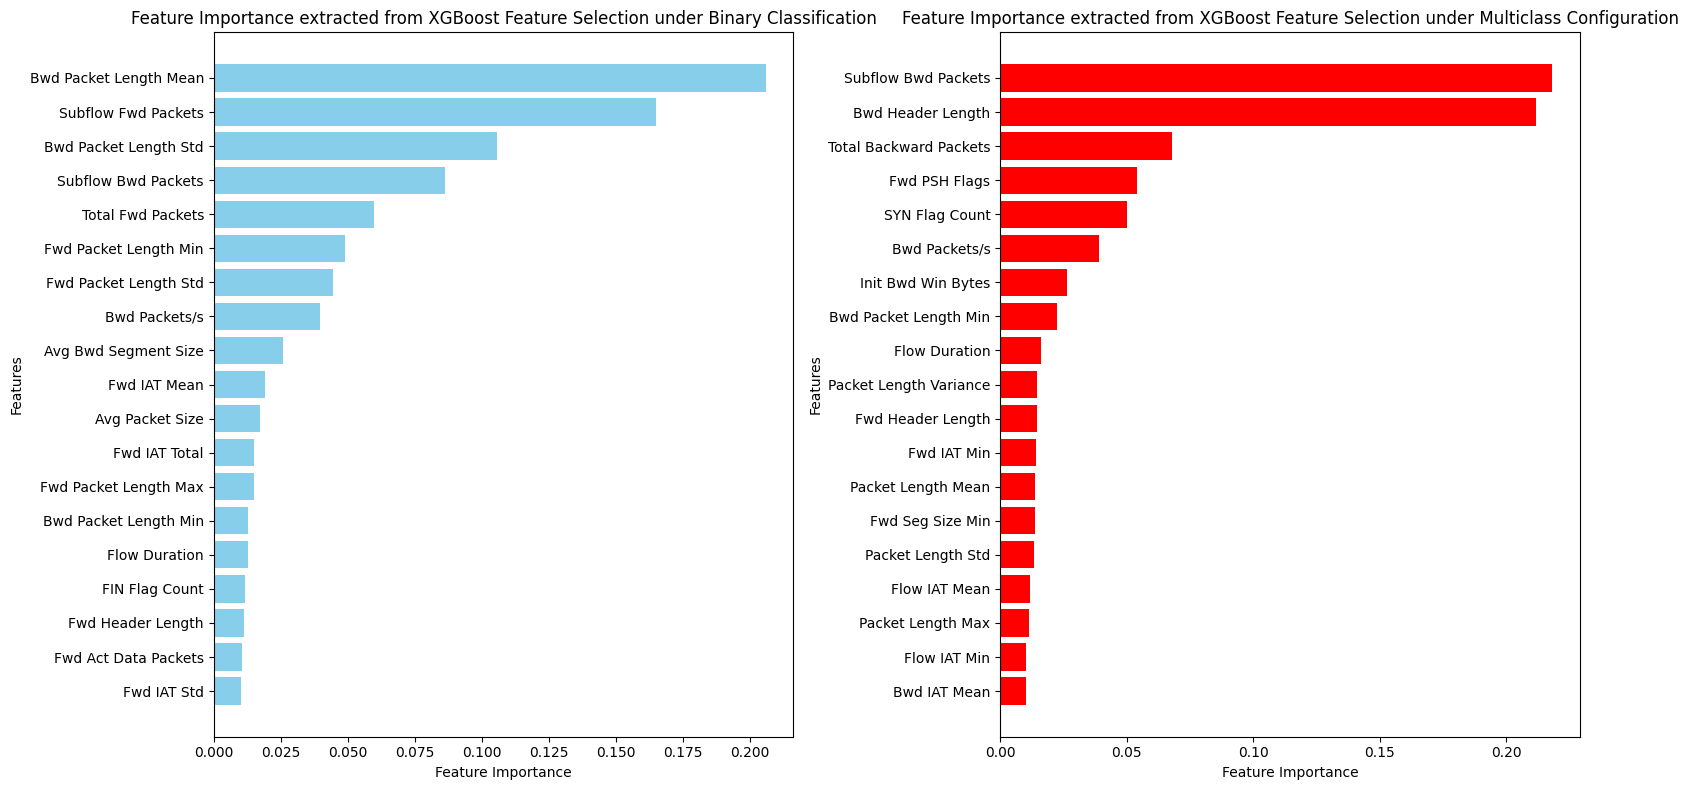

In [44]:

# Define figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Extracting feature names and their corresponding significance scores from feature_tuples_b
feature_names_b       = [tup[0] for tup in feature_tuples_b]
significance_scores_b = [tup[1] for tup in feature_tuples_b]

# Plot for binary configuration
axs[0].barh(feature_names_b, significance_scores_b, color='skyblue')
axs[0].set_xlabel('Feature Importance')
axs[0].set_ylabel('Features')
axs[0].set_title("Feature Importance extracted from XGBoost Feature Selection" +
                  " under Binary Classification")
axs[0].invert_yaxis()


# Extracting feature names and their corresponding significance scores from feature_tuples_b
feature_names_m       = [tup[0] for tup in feature_tuples_m]
significance_scores_m = [tup[1] for tup in feature_tuples_m]

# Plot for multi-class configuration
axs[1].barh(feature_names_m, significance_scores_m, color='red')
axs[1].set_xlabel('Feature Importance')
axs[1].set_ylabel('Features')
axs[1].set_title("Feature Importance extracted from XGBoost Feature Selection" + 
                 " under Multiclass Configuration")
axs[1].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()

### 1.4.5 Find the elements present in feature_names_b but not in feature_names_m

In [45]:

unique_in_b = set(feature_names_b) - set(feature_names_m)
# Find the elements present in feature_names_m but not in feature_names_b
unique_in_m = set(feature_names_m) - set(feature_names_b)

print("Unique elements not shared between 'feature_names_b' and 'feature_names_m':\n")
print("Binary configuration:")
print(unique_in_b)
print("")
print("Multi-class configuration:")
print(unique_in_m)

Unique elements not shared between 'feature_names_b' and 'feature_names_m':

Binary configuration:
{'Fwd IAT Std', 'Avg Bwd Segment Size', 'Fwd IAT Total', 'Subflow Fwd Packets', 'Bwd Packet Length Mean', 'Fwd IAT Mean', 'Fwd Packet Length Std', 'Avg Packet Size', 'Fwd Packet Length Min', 'Bwd Packet Length Std', 'FIN Flag Count', 'Fwd Packet Length Max', 'Total Fwd Packets', 'Fwd Act Data Packets'}

Multi-class configuration:
{'Packet Length Mean', 'Flow IAT Min', 'SYN Flag Count', 'Init Bwd Win Bytes', 'Bwd Header Length', 'Bwd IAT Mean', 'Packet Length Max', 'Packet Length Std', 'Fwd IAT Min', 'Fwd PSH Flags', 'Packet Length Variance', 'Flow IAT Mean', 'Fwd Seg Size Min', 'Total Backward Packets'}


> *We notice that the two configurations do not share all features!*

## 1.5 Feature Engineering under Binary Configuration

>* In our case, this operation was applied only to binary classification for two main reasons:
Binary classification has a greater class imbalance, as shown in Figure 2.4, requiring more optimization to improve performance.
In multi-class scenarios, adding new variables may introduce noise, reducing the model's ability to distinguish between similar attack types.

### 1.5.1 New Features

##### Combined Feature Importance

In [62]:
import pickle
from sklearn.preprocessing import Normalizer

def create_new_features_1(feature_tuples):
    """
    Cette fonction crée un score combiné basé sur l'importance des caractéristiques à partir des tuples de caractéristiques, 
    après avoir appliqué la normalisation sur les données.
    
    Args:
        feature_tuples (list): Une liste de tuples où chaque tuple contient le nom de la caractéristique et son poids d'importance.

    Returns:
        Pandas dataframes avec les caractéristiques d'origine et les scores combinés créés.
    """
    
    # Normalisation de X_train_selected_b
    normalizer = Normalizer()
    df_normalized_train = pd.DataFrame(normalizer.fit_transform(X_train_selected_b), 
                                       columns=X_train_selected_b.columns)
    
    # Sauvegarder le normalizer après l'entraînement
    with open('normalizer.pkl', 'wb') as f:
        pickle.dump(normalizer, f)
    
    # Normaliser X_val_selected_b et X_test_selected_b en utilisant le même normalizer
    df_normalized_val = pd.DataFrame(normalizer.transform(X_val_selected_b), 
                                     columns=X_val_selected_b.columns)
    df_normalized_test = pd.DataFrame(normalizer.transform(X_test_selected_b), 
                                      columns=X_test_selected_b.columns)

    # Extraire les noms des caractéristiques et les poids à partir des tuples
    feature_names, weights = zip(*feature_tuples)

    # Calculer la somme pondérée (sur les dataframes normalisées) basée sur l'importance des caractéristiques
    df_normalized_train["Combined_Importance_Score"] = df_normalized_train[list(feature_names)].dot(weights)
    df_normalized_val["Combined_Importance_Score"] = df_normalized_val[list(feature_names)].dot(weights)
    df_normalized_test["Combined_Importance_Score"] = df_normalized_test[list(feature_names)].dot(weights)

    # Retourner les dataframes normalisées
    return df_normalized_train, df_normalized_val, df_normalized_test


In [63]:
# 1.5.1.1.+ - Binary Implementation

# Check if feature_tuples exists
if 'feature_tuples_b' not in globals():
    # Call the function to create feature_tuples
    _, feature_tuples_b = select_features_by_threshold(original_data_b, clf_params=clf_params_b)

# Apply the function to training, validation, and test data
X_train_selected_b, X_val_selected_b, X_test_selected_b = create_new_features_1(feature_tuples_b)

##### Feature Ratio and Differences:

In [64]:
# 1.5.1.2 - Feature Ratio and Differences

def create_new_features_2(df):
    """
    This function creates new features based on Feature Ratio and Differences.

    Args:
        df: A pandas dataframe containing the selected features.

    Returns:
        A pandas dataframe with the original features and the newly created features.
    """
    # Standardized Difference: Packet Length Variation
    df["Packet_Length_Std_Diff"] = df["Bwd Packet Length Std"] - df["Packet Length Std"]
    
    # Length Difference
    df["Total_Packets_Diff"] = df["Total Fwd Packets"] - X["Total Backward Packets"]

    return df

In [65]:
# 1.5.1.2.+ - Binary Implementation

# Apply the function to training, validatio=n, and test data
#X_train_selected_b = create_new_features_2(X_train_selected_b)
#X_val_selected_b   = create_new_features_2(X_val_selected_b)
#X_test_selected_b  = create_new_features_2(X_test_selected_b)

##### Interaction Feature: 

In [66]:
# 1.5.1.3 - Feature Percentages

def create_new_features_3(df):
    """
    This function creates new features based on interaction of features.

    Args:
      df: A pandas dataframe containing the selected features.

    Returns:
      A pandas dataframe with the original features and the newly created features.
    """
    # Interaction features: Product of features
    df["Bwd_Fwd_Product"] = df["Bwd Packets/s"] * df["Flow Duration"]
    
    return df

In [67]:
# 1.5.1.3.+ - Binary Implementation

# Apply the function to training, validation, and test data
X_train_selected_b = create_new_features_3(X_train_selected_b)
X_val_selected_b   = create_new_features_3(X_val_selected_b)
X_test_selected_b  = create_new_features_3(X_test_selected_b)

### 1.5.2 Secondary Evaluation with XGBOOST

In [46]:
# 1.5.2.1 - Conduct evaluation of the new features

# Arrange selected data as a list
selected_data_b = [X_train_selected_b, X_val_selected_b, X_test_selected_b,
                   y_train_b, y_val_b, y_test_b]

# Extract features
X_train_final_b, X_val_final_b, X_test_final_b, feature_tuples_final_b = select_features_by_threshold(
               selected_data_b, clf_params=clf_params_b, threshold=0.01, printing=True)

# Arrange final data as a list
final_data_b = [X_train_final_b, X_val_final_b, X_test_final_b, y_train_b, y_val_b, y_test_b]

The number of selected features are: 16 

Feature Name          	Importance

Avg Bwd Segment Size  	31.81%
Bwd Packet Length Std 	22.51%
Subflow Fwd Packets   	9.38%
Fwd IAT Std           	7.18%
Fwd IAT Total         	4.83%
Bwd Packet Length Mean	3.64%
Bwd Packets/s         	2.68%
Fwd IAT Mean          	2.61%
FIN Flag Count        	2.35%
Fwd Packet Length Std 	2.15%
Avg Packet Size       	2.14%
Fwd Header Length     	1.77%
Bwd Packet Length Min 	1.71%
Subflow Bwd Packets   	1.51%
Fwd Packet Length Max 	1.50%
Flow Duration         	1.01%


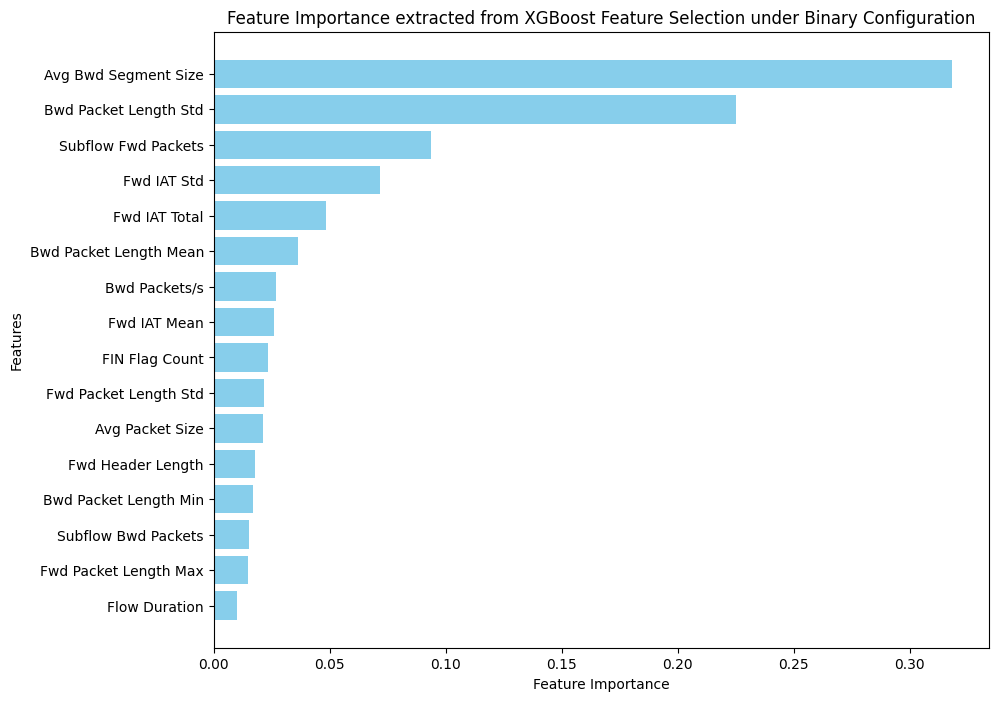

In [47]:
# 1.5.2.2 - Plotting Feature Importance

# Extracting feature names and their corresponding significance scores from feature_tuples_final
feature_names_final_b       = [tup[0] for tup in feature_tuples_final_b]
significance_scores_final_b = [tup[1] for tup in feature_tuples_final_b]

# Plotting the horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(feature_names_final_b, significance_scores_final_b, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance extracted from XGBoost Feature Selection'+
          ' under Binary Configuration')
# Invert y-axis to display features from top to bottom
plt.gca().invert_yaxis()  
plt.show()

## 1.8 SMOTE: Synthetic Minority Oversampling Technique for Imbalanced Datasets

In [48]:
# Sampling strategy '0.5' corresponds to binary classification
#smote = SMOTE(sampling_strategy = 0.5, random_state=seed_pi)
#X_train_final_b, y_train_b = smote.fit_resample(X_train_final_b, y_train_b)
# SMOTE pour la classification multiclasse
smote_multi = SMOTE(sampling_strategy='not majority', random_state=seed_pi)

# Appliquer SMOTE uniquement sur l'ensemble d'entraînement multiclasse
X_train_m_res, y_train_m_res = smote_multi.fit_resample(X_train_selected_m, y_train_m)


# Arrange processed data as a list - Binary Configuration
processed_data_b    = [X_train_final_b, X_val_final_b, X_test_final_b, y_train_b, y_val_b, y_test_b]
# Arrange processed data as a list - Multiclass Configuration
processed_data_m = [X_train_selected_m,X_val_selected_m,X_test_selected_m,y_train_m,y_val_m,y_test_m]

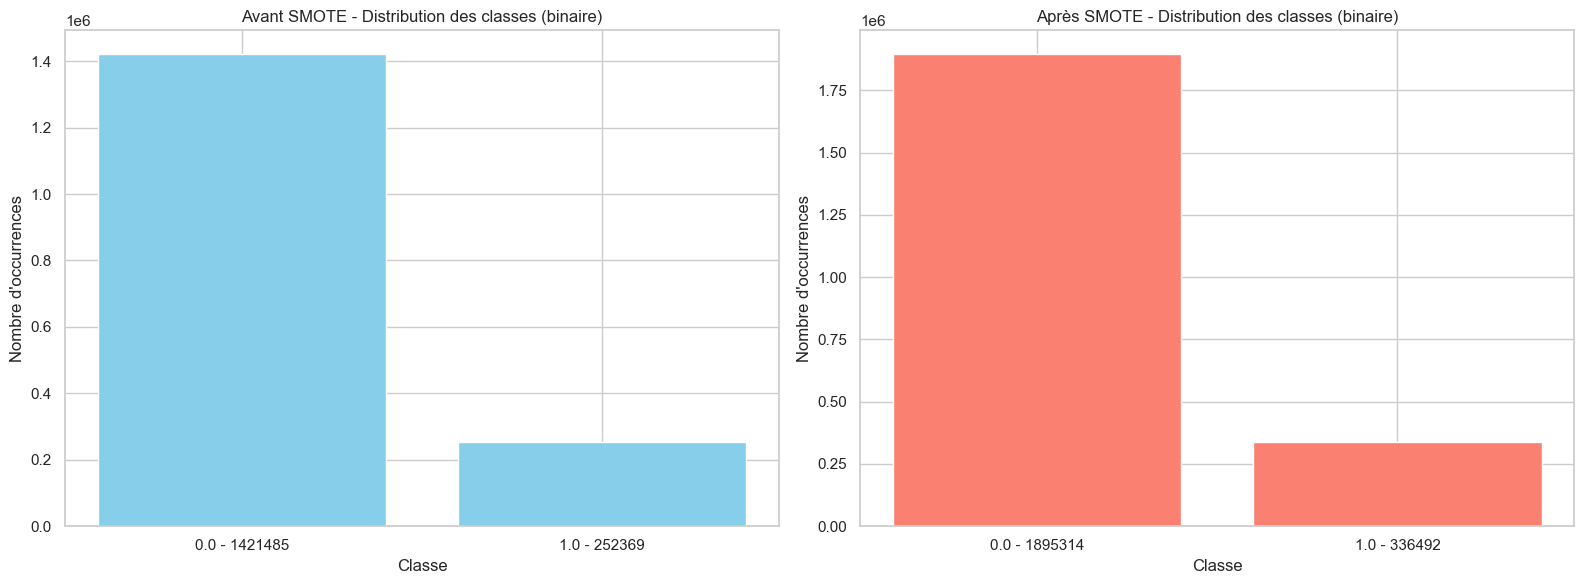

In [49]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Ancienne distribution : y_bal (avant oversampling)
counter_bal = Counter(y_train_b)
sizes_old = list(counter_bal.values())
labels_old = [f"{label} - {count}" for label, count in counter_bal.items()]

# === Nouvelle distribution : y_b (après oversampling)
# Assure-toi que y_b est bien concaténé comme tu l'as fait :
# y_b = pd.concat([y_train_b, y_val_b, y_test_b], ignore_index=True)
counter_new = Counter(y_b)
sizes_new = list(counter_new.values())
labels_new = [f"{label} - {count}" for label, count in counter_new.items()]

# === Plot side-by-side
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Ancienne distribution (avant SMOTE)
axs[0].bar(labels_old, sizes_old, color='skyblue')
axs[0].set_title("Avant SMOTE - Distribution des classes (binaire)")
axs[0].set_xlabel("Classe")
axs[0].set_ylabel("Nombre d'occurrences")

# Nouvelle distribution (après SMOTE)
axs[1].bar(labels_new, sizes_new, color='salmon')
axs[1].set_title("Après SMOTE - Distribution des classes (binaire)")
axs[1].set_xlabel("Classe")
axs[1].set_ylabel("Nombre d'occurrences")

plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_19484\2325545747.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_b, palette='Blues', ax=axs[0])
C:\Users\Admin\AppData\Local\Temp\ipykernel_19484\2325545747.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y_m, palette='Set2', ax=axs[1])


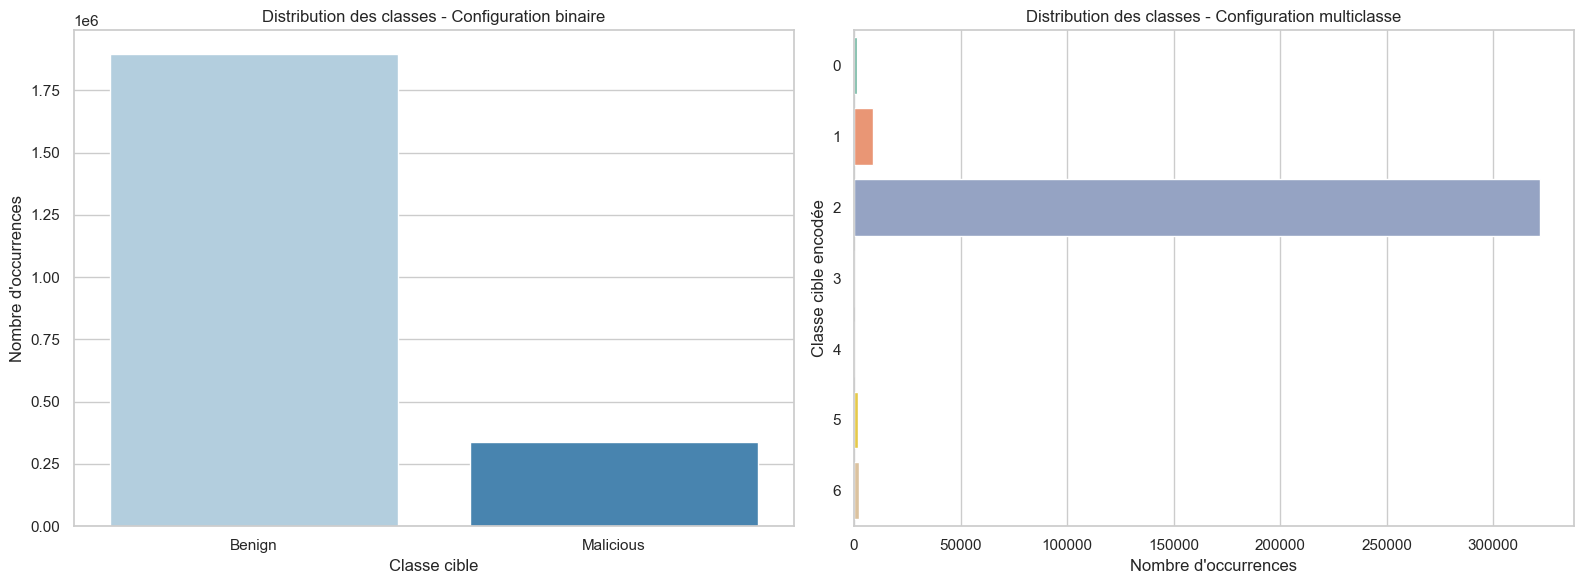

✅ Distribution des classes - Binaire :
Label
0.0    84.92%
1.0    15.08%
Name: proportion, dtype: object

✅ Distribution des classes - Multiclasse :
2    95.62%
1     2.72%
6     0.64%
5     0.58%
0     0.43%
4     0.01%
3     0.00%
Name: proportion, dtype: object


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Déballer les listes
X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b = processed_data_b
X_train_m, X_val_m, X_test_m, y_train_m, y_val_m, y_test_m = processed_data_m

# Concaténer les labels
y_b = pd.concat([y_train_b, y_val_b, y_test_b], ignore_index=True)
y_m = pd.concat([y_train_m, y_val_m, y_test_m], ignore_index=True)

# Style seaborn
sns.set(style="whitegrid")

# Création des subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Configuration Binaire
sns.countplot(x=y_b, palette='Blues', ax=axs[0])
axs[0].set_title('Distribution des classes - Configuration binaire')
axs[0].set_xlabel('Classe cible')
axs[0].set_ylabel('Nombre d\'occurrences')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Benign', 'Malicious'])

# Configuration Multiclasse
sns.countplot(y=y_m, palette='Set2', ax=axs[1])
axs[1].set_title('Distribution des classes - Configuration multiclasse')
axs[1].set_xlabel('Nombre d\'occurrences')
axs[1].set_ylabel('Classe cible encodée')

# Ajustement
plt.tight_layout()
plt.show()

# Affichage des ratios

# Binaire
print("✅ Distribution des classes - Binaire :")
print(y_b.value_counts(normalize=True).apply(lambda x: f"{x*100:.2f}%"))

# Multiclasse
print("\n✅ Distribution des classes - Multiclasse :")
print(y_m.value_counts(normalize=True).apply(lambda x: f"{x*100:.2f}%"))


# 2. Binary Classification Using MLPs for Intrusion Detection

In [73]:
# 2.0 - Delete variables to free memory space for traininig

del df_data_1, df_data_2, df_data_3, df_data_4, df_data_5, df_data_6, df_data_7, df_data_8
""" Binary Configuration """
del original_data_b, X_train_b, X_val_b, X_test_b
del selected_data_b, X_train_selected_b, X_val_selected_b, X_test_selected_b
# del final_data_b, X_train_final_b, X_val_final_b, X_test_final_b
""" Multiclass Configuration """
del original_data_m, X_train_m, X_val_m, X_test_m
# del selected_data_m, X_train_selected_m, X_val_selected_m, X_test_selected_m

In [74]:
# 2.0 - Load the trained models

# Load the saved models for efficient workflows
#model_1_b = load_model('model_1_b.h5')
#model_2_b = load_model('model_2_b.h5')
#model_3_b = load_model('model_3_b.h5')
#model_4_b = load_model('model_4_b.h5')
#model_5_b = load_model('model_5_b.h5')

# # Arrange the models as a list
# models_b = [model_1_b, model_2_b, model_3_b, model_4_b, model_5_b]
# # Extract summary for models
# _, _, _, _, _ = [model.summary() for model in models_b]

## 2.1 - Defining the model architectures

>* We designed specific models for each type of classification, varying their architecture and complexity. The goal is to evaluate the impact of this complexity on the performance of an intrusion detection system.

In [75]:
# Renaming the scaled data:
[X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b] = processed_data_b

# Number of units in the Input layer
input_shape = X_train_b.shape[1]

# Binary model: model_1_b - The "minimal" architecture
model_1_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(8, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(4,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform())])

# Binary model: model_2_b - An intermediate architecture
model_2_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(8,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform())])

# Binary model: model_3_b - An intermediate architecture
model_3_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(32, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu',    kernel_initializer=HeUniform()),
    Dense(8,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform())])

# Binary model: model_4_b - An intermediate architecture
model_4_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(128, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(32,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(16,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(8,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,   activation='sigmoid', kernel_initializer=GlorotUniform())])

# Binary model: model_5_b - The "maximal" architecture
model_5_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(256, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(128, activation='selu',    kernel_initializer=HeUniform()),
    Dense(64,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(32,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(16,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(8,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,   activation='sigmoid', kernel_initializer=GlorotUniform())])

models_b = [model_1_b, model_2_b, model_3_b, model_4_b, model_5_b]
# Extract summary for models
_, _, _, _, _ = [model.summary() for model in models_b]
# Extract the number of parameters for each model
num_params_b  = [model.count_params() for model in models_b]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 16)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 473 (1.85 KB)

 Trainable params: 473 (1.85 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 32)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,289 (5.04 KB)

 Trainable params: 1,289 (5.04 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 128)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,145 (27.91 KB)

 Trainable params: 7,145 (27.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                     │ (None, 256)                 │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,553 (189.66 KB)

 Trainable params: 48,553 (189.66 KB)

 Non-trainable params: 0 (0.00 B)

##### Defining parameters for the Training Sessions under Binary configuration

In [76]:
# Define Early Stopping callback to monitor validation loss
early_stopping_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=8,               # Stop training after 10 epochs with no improvement
    verbose=1,                 # Provide verbose output when early stopping is triggered
    restore_best_weights=True) # Restore model weights with best validation loss

# Define ReduceLROnPlateau scheduler, LR:Learning Rate
reduce_lr_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=4,                # Default value for patience is 10
    min_lr= 1e-07,             # min_lr: Minimum learning rate (deafault value=0.0001)
    verbose=0,                 # Providing verbose output when learning rate is reduced
    factor= 0.1)               # The default factor is 0.1, which reduces 
                               # the learning rate by 10% when triggered.
    
compilation_params_b = dict(
    optimizer='adam',          # Adam optimizer has default learning rate 1e-03
    loss='binary_crossentropy',# Binary crossentropy corresponds to binary Configuration 
    metrics=['accuracy'])      # montitor accuracy during training

## 2.2 training sessions

##### 1) Training Session for `model_1_b`

In [ ]:
# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metrics
model_1_b.compile(**compilation_params_b) 

# Parameters of the training session
fitting_params_b = dict(x=X_train_b, y=y_train_b, validation_data=(X_val_b, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_1_b = model_1_b.fit(**fitting_params_b)

##### 2) Training Session for `model_2_b`

In [ ]:
# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metrics
model_2_b.compile(**compilation_params_b) 

# Parameters of the training session
fitting_params_b = dict(x=X_train_b, y=y_train_b, validation_data=(X_val_b, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_2_b = model_2_b.fit(**fitting_params_b)

##### 3) Training Session for `model_3_b`

In [ ]:
# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metrics
model_3_b.compile(**compilation_params_b) 

# Parameters of the training session
fitting_params_b = dict(x=X_train_b, y=y_train_b, validation_data=(X_val_b, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_3_b = model_3_b.fit(**fitting_params_b)

##### 4) Training Session for `model_4_b`

In [ ]:
# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metrics
model_4_b.compile(**compilation_params_b) 

# Parameters of the training session
fitting_params_b = dict(x=X_train_b, y=y_train_b, validation_data=(X_val_b, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_4_b = model_4_b.fit(**fitting_params_b)

##### 5) Training Session for `model_5_b`

In [ ]:
# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metrics
model_5_b.compile(**compilation_params_b) 

# Parameters of the training session
fitting_params_b = dict(x=X_train_b, y=y_train_b, validation_data=(X_val_b, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_5_b = model_5_b.fit(**fitting_params_b)

## 2.3 Evaluation

### 2.3.1 Standard evaluation

for the evaluation, we use metrics such as  `accuracy` , `precision`, `recall` and `F1 score`.

In [ ]:
def evaluate_b(model, X_test, y_test):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predicted probabilities to class labels
    y_pred_labels = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels)
    recall    = recall_score(y_test, y_pred_labels)
    f1        = f1_score(y_test, y_pred_labels)

    # Print the evaluation metrics
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1 Score:  {f1*100:.2f}%")
    print("")
    
    return test_loss, test_accuracy, precision, recall, f1
    
[loss_1_b, acc_1_b, prec_1_b, recall_1_b, f1_1_b] = evaluate_b(model=model_1_b, 
                                              X_test=X_test_b, y_test=y_test_b)
[loss_2_b, acc_2_b, prec_2_b, recall_2_b, f1_2_b] = evaluate_b(model=model_2_b, 
                                              X_test=X_test_b, y_test=y_test_b)
[loss_3_b, acc_3_b, prec_3_b, recall_3_b, f1_3_b] = evaluate_b(model=model_3_b, 
                                              X_test=X_test_b, y_test=y_test_b)
[loss_4_b, acc_4_b, prec_4_b, recall_4_b, f1_4_b] = evaluate_b(model=model_4_b, 
                                              X_test=X_test_b, y_test=y_test_b)
[loss_5_b, acc_5_b, prec_5_b, recall_5_b, f1_5_b] = evaluate_b(model=model_5_b, 
                                              X_test=X_test_b, y_test=y_test_b)

### 2.3.2 Advanced Evaluation

We proceed with two advanced evaluation metrics, namely False Alarm Ratio `FAR` and Attack Miss Ratio `AMR`.

In [ ]:
def far_amr_b(model, X_test=X_test_b, y_test=y_test_b, plotting=True):
    """
    Advanced evaluation through False Alarm Ratio (FAR) & Attack Miss Ratio (AMR).
    """
    # Extract predictions from the test set
    y_pred = model.predict(X_test)
    # Convert predicted probabilities to class labels
    y_pred_labels = (y_pred > 0.5).astype(int)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_labels)

    # Plotting parameter exists for debugging purposes
    if plotting:
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    # Calculate FAR:
    true_positives  = conf_matrix[0,0]
    false_positives = conf_matrix[0,1] 
    all_positives   = true_positives + false_positives
    far = false_positives / all_positives
    #Calculate AMR:
    false_negatives = conf_matrix[1,0] 
    true_negatives  = conf_matrix[1,1]
    all_negatives   = true_negatives + false_negatives
    amr = false_negatives / all_negatives
    return far, amr
    
far_1_b, amr_1_b = far_amr_b(model_1_b, plotting=False)
far_2_b, amr_2_b = far_amr_b(model_2_b, plotting=False)
far_3_b, amr_3_b = far_amr_b(model_3_b, plotting=False)
far_4_b, amr_4_b = far_amr_b(model_4_b, plotting=False)
far_5_b, amr_5_b = far_amr_b(model_5_b, plotting=False)

print("")
print(f"Model_1_b: (FAR, AMR) = ({far_1_b:.4f}, {amr_1_b:.4f})")
print(f"Model_2_b: (FAR, AMR) = ({far_2_b:.4f}, {amr_2_b:.4f})")
print(f"Model_3_b: (FAR, AMR) = ({far_3_b:.4f}, {amr_3_b:.4f})")
print(f"Model_4_b: (FAR, AMR) = ({far_4_b:.4f}, {amr_4_b:.4f})")
print(f"Model_5_b: (FAR, AMR) = ({far_5_b:.4f}, {amr_5_b:.4f})")

### 2.3.3 Plotting history: train & validation loss and accuracy over epochs

In [ ]:

def history_plot(history, model_name):
    """
    Plotting the loss & accuracy history of the model
    """
    
    # Suppress FutureWarnings within this function
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Extract training and validation loss/accuracy from history
        train_loss = history.history['loss']
        val_loss   = history.history['val_loss']
        train_acc  = history.history['accuracy']
        val_acc    = history.history['val_accuracy']

        # Create a figure and axes for subplots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

        # Plot loss curves
        sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=axes[0], label='Training Loss')
        sns.lineplot(x=range(len(val_loss)),   y=val_loss, ax=axes[0], label='Validation Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title(f'Loss for {model_name}')
        axes[0].legend()
        axes[0].grid(True)

        # Plot accuracy curves
        sns.lineplot(x=range(len(train_acc)), y=train_acc, ax=axes[1], label='Training Accuracy')
        sns.lineplot(x=range(len(val_acc)),   y=val_acc, ax=axes[1], label='Validation Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title(f'Accuracy for {model_name}')
        axes[1].legend()
        axes[1].grid(True)

        # Adjust layout
        plt.tight_layout()

        # Display the plot
        plt.show()

print("History for model_1_b\n")
history_plot(history_1_b, "model_1_b")
print("")
print("History for model_2_b\n")
history_plot(history_2_b, "model_2_b")
print("")
print("History for model_3_b\n")
history_plot(history_3_b, "model_3_b")
print("")
print("History for model_4_b\n")
history_plot(history_4_b, "model_4_b")
print("")
print("History for model_5_b\n")
history_plot(history_5_b, "model_5_b")

### 2.3.4  Plotting accuracy vs. number of parameters trade-off

In [ ]:

acc_b = [acc_1_b, acc_2_b, acc_3_b, acc_4_b, acc_5_b]

plt.plot(num_params_b, acc_b, marker='o')
plt.title('Accuracy vs Number of Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Depictions of training and validation loss, as well as accuracy, (over the epochs) are provided in diagrams below.

Lastly, models will be evaluated on **latency**:

### 2.3.5  Measure latency

In [ ]:
# Measure latency
def latency(model, sample_data):
    start_time = time.time()
    model.predict(sample_data)
    end_time = time.time()
    latency = (end_time - start_time) / len(sample_data)
    return latency

# Measure & Print latency
print(f"Latency for model_1_b: {latency(model_1_b, X_test_b)*1000:.3f} ms") # Results: 0.049 m-seconds
print(f"Latency for model_2_b: {latency(model_2_b, X_test_b)*1000:.3f} ms") # Results: 0.048 m-seconds
print(f"Latency for model_3_b: {latency(model_3_b, X_test_b)*1000:.3f} ms") # Results: 0.061 m-seconds
print(f"Latency for model_4_b: {latency(model_4_b, X_test_b)*1000:.3f} ms") # Results: 0.050 m-seconds
print(f"Latency for model_5_b: {latency(model_5_b, X_test_b)*1000:.3f} ms") # Results: 0.061 m-seconds

###  2.3.6 plotting confusion matrix 

In [ ]:
# Affichage des matrices de confusion des modeles binaires
y_pred_1 = model_1_b.predict(X_test_b)
y_pred_2 = model_2_b.predict(X_test_b)
y_pred_3 = model_3_b.predict(X_test_b)
y_pred_4 = model_4_b.predict(X_test_b)
y_pred_5 = model_5_b.predict(X_test_b)

### 2.4  Save the models

In [ ]:
# Save model_1_b
model_1_b.save('model_1_b.keras')
# Save model_2_b
model_2_b.save('model_2_b.keras')
# Save model_3_b
model_3_b.save('model_3_b.keras')
# Save model_4_b
model_4_b.save('model_4_b.keras')
# Save model_5_b
model_5_b.save('model_5_b.keras')

# 3. Multiclass Training Using MLPs for Intrusion Detection

## 3.1 - Defining the model architectures

In [78]:


# Renaming the scaled data:
[X_train_m, X_val_m, X_test_m, y_train_m, y_val_m, y_test_m] = processed_data_m

# Number of units in the Input layer
input_shape = X_train_m.shape[1]

# Multiclass model: model_1_m - The "minimal" architecture
model_1_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

# Multiclass model: model_2_m - An intermediate architecture
model_2_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

# Multiclass model: model_3_m - An intermediate architecture
model_3_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

# multiclass model: model_4_m - An intermediate architecture
model_4_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

# multiclass model: model_5_m - The "maximal" architecture
model_5_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(32, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

models_m = [model_1_m, model_2_m, model_3_m, model_4_m, model_5_m]
# Extract summary for models
_, _, _, _, _ = [model.summary() for model in models_m]
# Extract the number of parameters for each model
num_params_m  = [model.count_params() for model in models_m]

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 680 (2.66 KB)

 Trainable params: 680 (2.66 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 952 (3.72 KB)

 Trainable params: 952 (3.72 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,224 (4.78 KB)

 Trainable params: 1,224 (4.78 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,496 (5.84 KB)

 Trainable params: 1,496 (5.84 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,032 (19.66 KB)

 Trainable params: 5,032 (19.66 KB)

 Non-trainable params: 0 (0.00 B)

##### Defining parameters for the Training Sessions under Multiclass configuration

In [79]:


# Define Early Stopping callback to monitor validation loss
early_stopping_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=8,                # Stop training after 10 epochs with no improvement
    verbose=1,                 # Provide verbose output when early stopping is triggered
    restore_best_weights=True) # Restore model weights with best validation loss

# Define ReduceLROnPlateau scheduler, LR:Learning Rate
reduce_lr_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=4,                # Default value for patience is 10
    min_lr= 1e-07,             # min_lr: Minimum learning rate (deafault value=0.0001)
    verbose=0,                 # Providing verbose output when learning rate is reduced
    factor= 0.1)               # The default factor is 0.1, which reduces 
                               # the learning rate by 10% when triggered.
    
compilation_params_m = dict(
    optimizer='adam',          # Adam optimizer has default learning rate 1e-03
    loss='sparse_categorical_crossentropy',  # Sparse categoriical crossentropy 
                                             # corresponds to Multiclass Configuration 
    metrics=['accuracy'])      # montitor accuracy during training

## 3.2 training sessions

### 3.2.1 - Training Session for `model_1_m`

In [80]:
# 3.2.1 - Training Session for `model_1_m`

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
model_1_m.compile(**compilation_params_m) 

# Parameters of the training session
fitting_params_m = dict(x=X_train_m, y=y_train_m, validation_data=(X_val_m, y_val_m),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_1_m = model_1_m.fit(**fitting_params_m)

Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 4.


### 3.2.2 - Training Session for `model_2_m`

In [81]:

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
model_2_m.compile(**compilation_params_m) 

# Parameters of the training session
fitting_params_m = dict(x=X_train_m, y=y_train_m, validation_data=(X_val_m, y_val_m),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_2_m = model_2_m.fit(**fitting_params_m)

Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 4.


### 3.2.3 - Training Session for `model_3_m`

In [82]:


# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
model_3_m.compile(**compilation_params_m) 

# Parameters of the training session
fitting_params_m = dict(x=X_train_m, y=y_train_m, validation_data=(X_val_m, y_val_m),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_3_m = model_3_m.fit(**fitting_params_m)

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 2.


### 3.2.4 - Training Session for `model_4_m`

In [83]:

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
model_4_m.compile(**compilation_params_m) 

# Parameters of the training session
fitting_params_m = dict(x=X_train_m, y=y_train_m, validation_data=(X_val_m, y_val_m),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_4_m = model_4_m.fit(**fitting_params_m)

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 2.


### 3.2.5 - Training Session for `model_5_m`

In [84]:
# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
model_5_m.compile(**compilation_params_m) 

# Parameters of the training session
fitting_params_m = dict(x=X_train_m, y=y_train_m, validation_data=(X_val_m, y_val_m),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_5_m = model_5_m.fit(**fitting_params_m)

Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 7.


## 3.3  Evaluation

### 3.3.1 - Standard Evaluation

In [85]:


def evaluate_m(model, X_test, y_test):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels, average='weighted', zero_division=1)
    recall    = recall_score(y_test, y_pred_labels, average='weighted', zero_division=1)
    f1        = f1_score(y_test, y_pred_labels, average='weighted', zero_division=1)

    # Print the evaluation metrics
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1 Score:  {f1*100:.2f}%")
    print("")
    
    return test_loss, test_accuracy, precision, recall, f1
    
[loss_1_m, acc_1_m, prec_1_m, recall_1_m, f1_1_m] = evaluate_m(model_1_m,
                X_test=X_test_m, y_test=y_test_m)
[loss_2_m, acc_2_m, prec_2_m, recall_2_m, f1_2_m] = evaluate_m(model_2_m,
                X_test=X_test_m, y_test=y_test_m)
[loss_3_m, acc_3_m, prec_3_m, recall_3_m, f1_3_m] = evaluate_m(model_3_m,
                X_test=X_test_m, y_test=y_test_m)
[loss_4_m, acc_4_m, prec_4_m, recall_4_m, f1_4_m] = evaluate_m(model_4_m,
                X_test=X_test_m, y_test=y_test_m)
[loss_5_m, acc_5_m, prec_5_m, recall_5_m, f1_5_m] = evaluate_m(model_5_m,
                X_test=X_test_m, y_test=y_test_m)

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7379 - loss: 0.5780
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
Test Loss:      0.5847
Test Accuracy:  73.40%
Test Precision: 80.88%
Test Recall:    73.40%
Test F1 Score:  69.52%

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7454 - loss: 0.5246
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step
Test Loss:      0.5307
Test Accuracy:  74.17%
Test Precision: 81.25%
Test Recall:    74.17%
Test F1 Score:  70.21%

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7346 - loss: 0.5509
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test Loss:      0.5568
Test Accuracy:  73.15%
Test Precision: 80.59%
Test Recall:    73.15%
Test F1 Score:  69.08%

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7400 - loss: 0.5638
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test Loss:      0.5708
Test Accuracy:  73.61%
Test Precision: 81.29%
Test Recall:    73.61%
Test F1 Score:  69.85%

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accurac

### 3.3.2 - Advanced Evaluation

In [86]:


def far(conf_matrix, benign_index):
    # Calculate the total number of instances for the Benign Class
    total_benign_instances = np.sum(conf_matrix[benign_index,:])
    # Calculate the False Positives of the Benign Class
    false_positives = total_benign_instances - conf_matrix[benign_index, benign_index]
    # Calculate FAR
    far = false_positives / total_benign_instances
    return far

def amr(conf_matrix, benign_index):
    # Calculate the total number of instances for the Benign Class
    total_benign_instances = np.sum(conf_matrix[benign_index,:])
    # Calculate the total number of instances for all classes
    total_instances = np.sum(conf_matrix)
    # Extract the total number of attack/malicious instances
    total_attack_instances = total_instances - total_benign_instances
    # Calculate the False Positives for the union of all attacks
    false_positives = np.sum(conf_matrix[benign_index + 1:, benign_index], axis=0)
    # Calculate AMR
    amr = false_positives / total_attack_instances
    return amr

def far_amr_m(model, X_test=X_test_m, y_test=y_test_m, plotting=True):
    """
    Advanced evaluation through False Alarm Ratio (FAR) & Attack Miss Ratio (AMR).
    """
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_labels)

    # Plotting parameter exists for debugging purposes
    if plotting:
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    far_m = far(conf_matrix=conf_matrix, benign_index=0)
    amr_m = amr(conf_matrix=conf_matrix, benign_index=0)
    return far_m, amr_m
    
far_1_m, amr_1_m = far_amr_m(model_1_m, plotting=False)
far_2_m, amr_2_m = far_amr_m(model_2_m, plotting=False)
far_3_m, amr_3_m = far_amr_m(model_3_m, plotting=False)
far_4_m, amr_4_m = far_amr_m(model_4_m, plotting=False)
far_5_m, amr_5_m = far_amr_m(model_5_m, plotting=False)

print("")
print(f"Model_1_m: (FAR, AMR) = ({far_1_m:.4f}, {amr_1_m:.4f})")
print(f"Model_2_m: (FAR, AMR) = ({far_2_m:.4f}, {amr_2_m:.4f})")
print(f"Model_3_m: (FAR, AMR) = ({far_3_m:.4f}, {amr_3_m:.4f})")
print(f"Model_4_m: (FAR, AMR) = ({far_4_m:.4f}, {amr_4_m:.4f})")
print(f"Model_5_m: (FAR, AMR) = ({far_5_m:.4f}, {amr_5_m:.4f})")

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Model_1_m: (FAR, AMR) = (1.0000, 0.0000)
Model_2_m: (FAR, AMR) = (1.0000, 0.0000)
Model_3_m: (FAR, AMR) = (1.0000, 0.0000)
Model_4_m: (FAR, AMR) = (0.6791, 0.0011)
Model_5_m: (FAR, AMR) = (0.6791, 0.0000)


### 3.3.3 - Plotting history: train & validation loss and accuracy over epochs


History for model_1_m



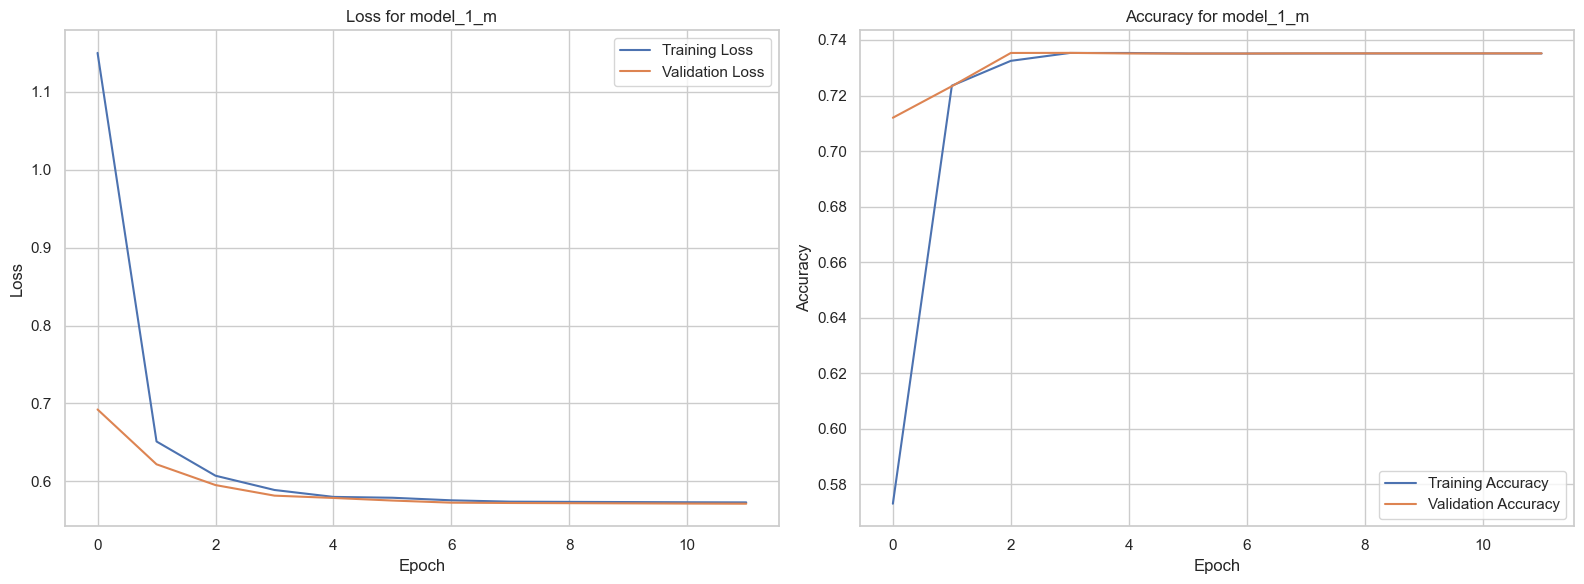


History for model_2_m



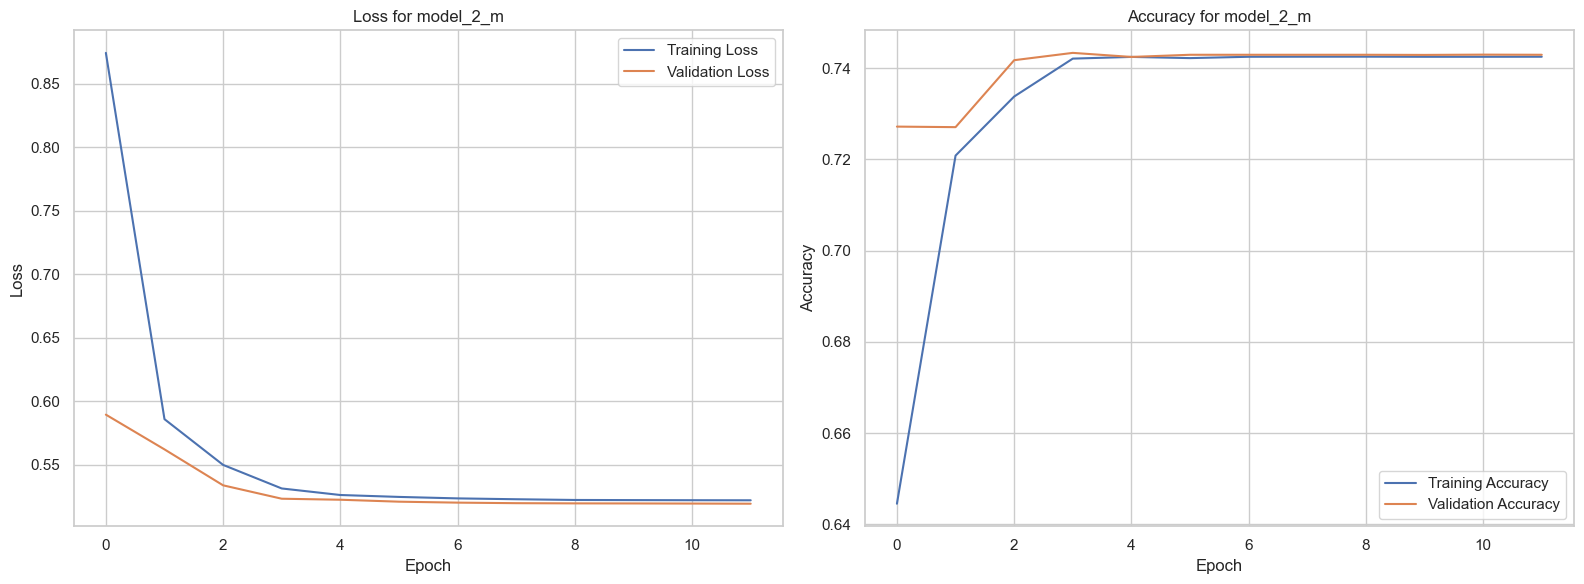


History for model_3_m



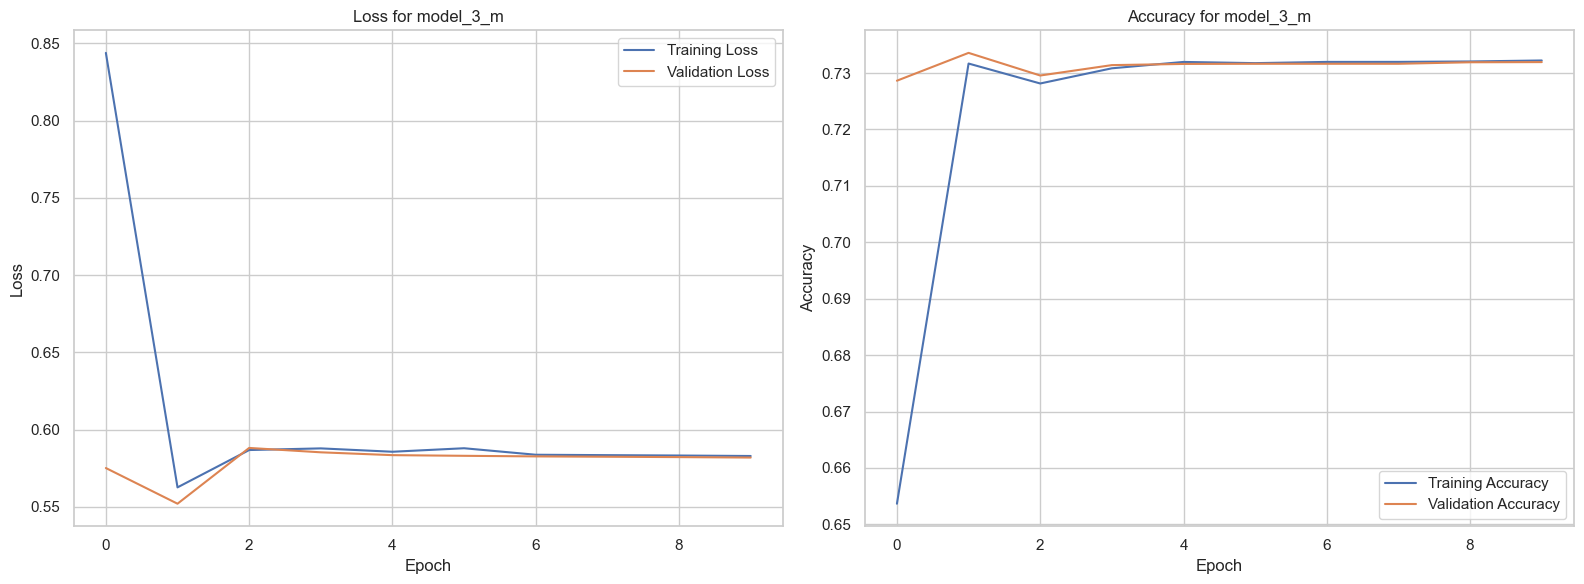


History for model_4_m



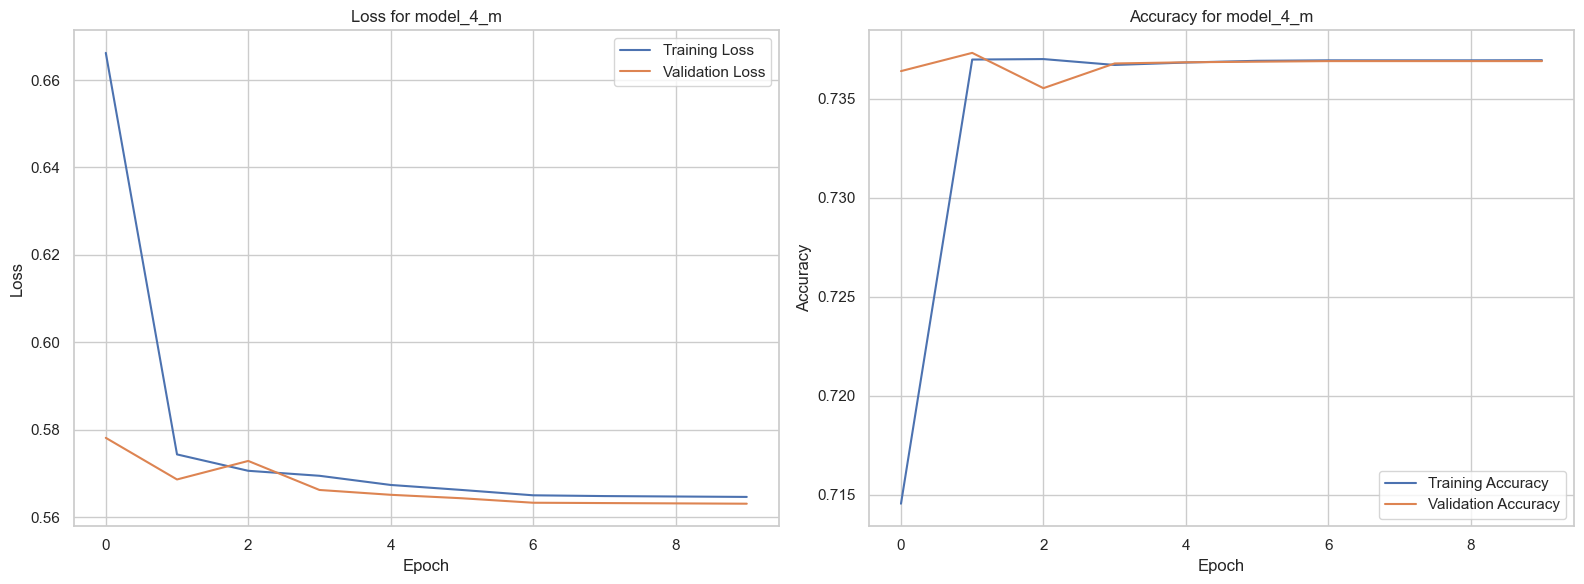


History for model_5_m



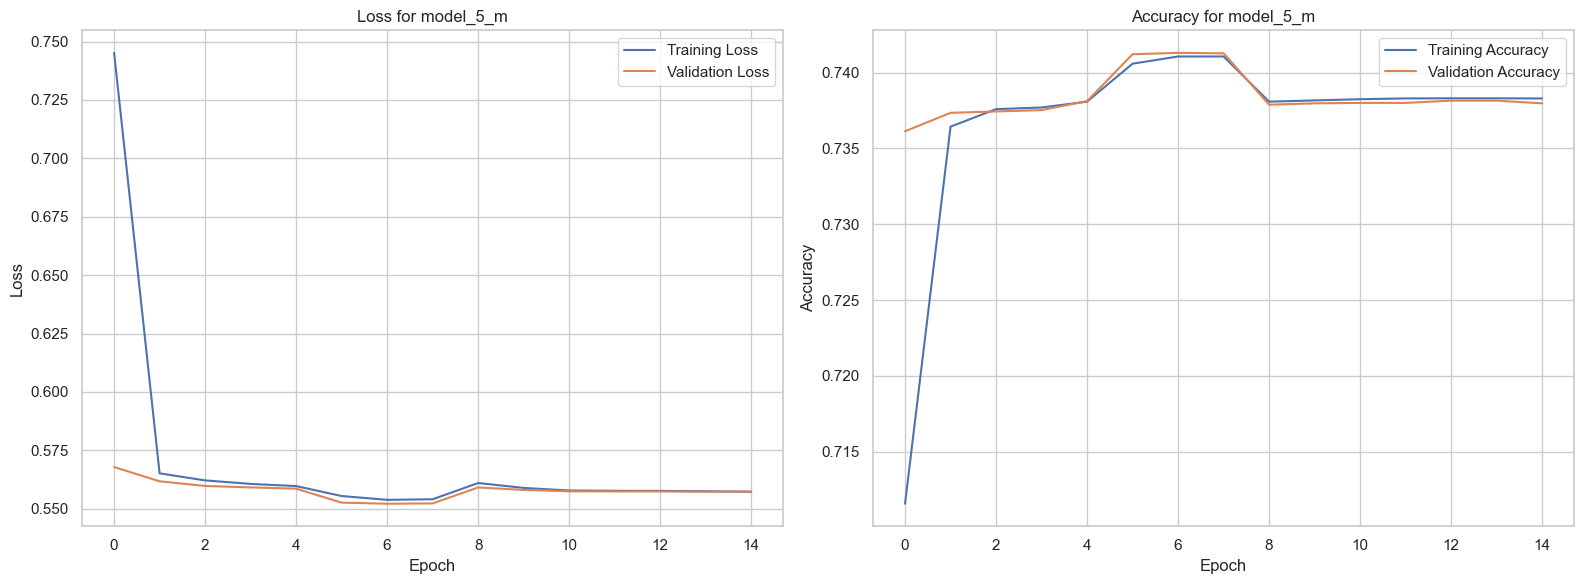

In [88]:

def history_plot(history, model_name):
    """
    Plotting the loss & accuracy history of the model
    """
    
    # Suppress FutureWarnings within this function
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Extract training and validation loss/accuracy from history
        train_loss = history.history['loss']
        val_loss   = history.history['val_loss']
        train_acc  = history.history['accuracy']
        val_acc    = history.history['val_accuracy']

        # Create a figure and axes for subplots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

        # Plot loss curves
        sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=axes[0], label='Training Loss')
        sns.lineplot(x=range(len(val_loss)),   y=val_loss, ax=axes[0], label='Validation Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title(f'Loss for {model_name}')
        axes[0].legend()
        axes[0].grid(True)

        # Plot accuracy curves
        sns.lineplot(x=range(len(train_acc)), y=train_acc, ax=axes[1], label='Training Accuracy')
        sns.lineplot(x=range(len(val_acc)),   y=val_acc, ax=axes[1], label='Validation Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title(f'Accuracy for {model_name}')
        axes[1].legend()
        axes[1].grid(True)

        # Adjust layout
        plt.tight_layout()

        # Display the plot
        plt.show()

print("History for model_1_m\n")
history_plot(history_1_m, "model_1_m")
print("")
print("History for model_2_m\n")
history_plot(history_2_m, "model_2_m")
print("")
print("History for model_3_m\n")
history_plot(history_3_m, "model_3_m")
print("")
print("History for model_4_m\n")
history_plot(history_4_m, "model_4_m")
print("")
print("History for model_5_m\n")
history_plot(history_5_m, "model_5_m")

### 3.3.4 - Plotting accuracy vs. number of parameters trade-off

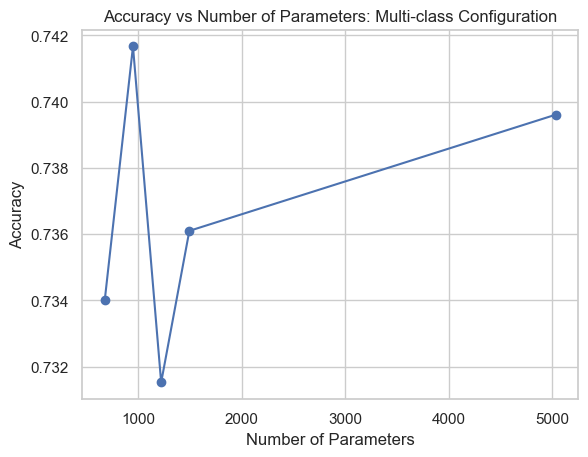

In [89]:
acc_m = [acc_1_m, acc_2_m, acc_3_m, acc_4_m, acc_5_m]

# Plot
plt.plot(num_params_m, acc_m, marker='o')
plt.title('Accuracy vs Number of Parameters: Multi-class Configuration')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### 3.3.5 - Measure latency

In [91]:

def latency(model, sample_data):
    start_time = time.time()
    model.predict(sample_data)
    end_time = time.time()
    latency = (end_time - start_time) / len(sample_data)
    return latency
# Measure & Print latency
print(f"Latency for model_1_m: {latency(model_1_m, X_test_m)*1000:.3f} ms") # Results: 0.052 m-seconds
print(f"Latency for model_2_m: {latency(model_2_m, X_test_m)*1000:.3f} ms") # Results: 0.052 m-seconds
print(f"Latency for model_3_m: {latency(model_3_m, X_test_m)*1000:.3f} ms") # Results: 0.053 m-seconds
print(f"Latency for model_4_m: {latency(model_4_m, X_test_m)*1000:.3f} ms") # Results: 0.051 m-seconds
print(f"Latency for model_5_m: {latency(model_5_m, X_test_m)*1000:.3f} ms") # Results: 0.049 m-seconds

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step
Latency for model_1_m: 0.042 ms
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
Latency for model_2_m: 0.046 ms
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
Latency for model_3_m: 0.044 ms
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
Latency for model_4_m: 0.049 ms
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
Latency for model_5_m: 0.042 ms


### 3.3.6 plotting confusion matrix

In [99]:
y_pred_1 = np.argmax(y_pred_1, axis=1)  # Prend la classe avec la plus grande probabilité
y_pred_2 = np.argmax(y_pred_2, axis=1)
y_pred_3 = np.argmax(y_pred_3, axis=1)
y_pred_4 = np.argmax(y_pred_4, axis=1)
y_pred_5 = np.argmax(y_pred_5, axis=1)

## 3.4 - Save the models

In [93]:
# Save model_1_b
model_1_m.save('model_1_m.keras')
# Save model_2_b
model_2_m.save('model_2_m.keras')
# Save model_3_b
model_3_m.save('model_3_m.keras')
# Save model_4_b
model_4_m.save('model_4_m.keras')
# Save model_5_b
model_5_m.save('model_5_m.keras')

##### Sauvegarde du LabelEncoder

In [97]:
# Création et entraînement du LabelEncoder
#label_encoder = LabelEncoder()
#classes = [ "DoS", "BruteForce", "Web Attack", "PortScan", "Bot", "Infiltration", "Heartbleed"]
#label_encoder.fit(classes)  # On force l'encodeur à apprendre ces classes
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Encodeur sauvegardé avec les classes :", label_encoder.classes_)

Encodeur sauvegardé avec les classes : ['Bot' 'BruteForce' 'DoS' 'Heartbleed' 'Infiltration' 'PortScan'
 'Web Attack']


##### Sauvegarde du Normalizer

In [ ]:
joblib.dump(normalizer, 'normalizer.pkl')


In [ ]:
from tensorflow import keras

# Charger le modèle Keras
model = keras.models.load_model('model_1_m.keras')

# Afficher un résumé du modèle
model.summary()


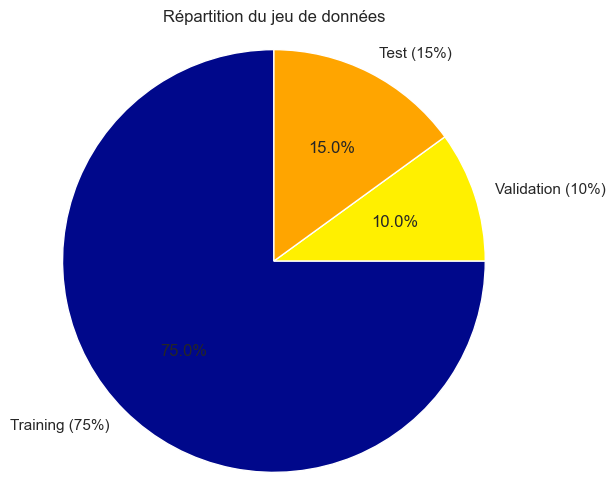

In [115]:
import matplotlib.pyplot as plt

# Proportions des ensembles
labels = ['Training (75%)', 'Validation (10%)', 'Test (15%)']
sizes = [75, 10, 15]
couleurs_modifiees = ['#00088B', '#FFF000', '#FFA500'] # Bleu foncé, Jaune, Orange (pour une meilleure visibilité avec le jaune)

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=couleurs_modifiees)
plt.title('Répartition du jeu de données')
plt.axis('equal')  # Assure un cercle parfait
plt.show()